
<h2><center><font color='black'>   Taking a Deep-Learning Dive with Keras </font></center></h2>

<img src='../imgs/Deep_Dive_Keras_3.jpg'/>

## Recurrent Neural Nets


###  Snippet of a fully connected model
<img src='../imgs/full_connect.png'/>

### Snippet of RNN
<img src='../imgs/rnn3.jpg'/>

#### Our recurrence formula:
$$s_t=f_W(s_{t-1},x_t)$$

(where ht: new state, f~function with parameters W, ht-1: previous, 
h_t=tanh(Whh(ht-1) + Wxh(xt))
yt=Why(h_t)

#### Pseudo-code example:  RNN for text 'generation' 

In [ ]:

Vocab_size =1000 
hidden_layer=100

# U ~ 100x 1000
# V ~ 1000 x 100
# W ~ 100 x 100 

time_steps = 10   #  where time_steps are # of words in sample

# define our state matrix:
# s = 10 X 100

# output
# o = 1 x 1000

for t in time_steps:
    #  U[x[t]   ~ essentially a look-up for U
    s[t]=np.tanh(U[x[t]] + np.dot(W,s[t-1]) 
    o[t] = softmax(V.dot(s[t]))
                 
## during backprop, we continue to update each matrix: U,V,W

### RNN: Process Sequences

<img src='imgs/rnn_one.png'/>

### LSTM  - Long Short Term Memory

<img src='imgs/lstm_3_anno.png'/>
<img src='imgs/lstm_eqn.png'/>

[credits: Colah's Blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

In [1]:
import numpy as np
np.random.seed(13)
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Activation, Bidirectional,\
     SimpleRNN, GRU, LSTM, Convolution1D, MaxPooling1D, Merge, Dropout, Convolution2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils.np_utils import to_categorical
from IPython.display import SVG

from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.utils.vis_utils import model_to_dot, plot_model

import keras

Using Theano backend.


## RNN Example: Text Classification

- We'll work with reuter newswire to classification dataset.   
- 46 classes
- We will model this using RNNs, but first let's try with an ANN. 

#### Ex 1: Reuters newswire data via ANN



In [2]:
max_features = 2000
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words=max_features)
maxlen = 10
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
nb_epoch = 20

1638400/2110848 [======================>.......] - ETA: 0s

In [3]:
# let's see how our data is returned
print(X_test[0])
print(y_test[0])
np.unique(y_test)

[324  27  56   2   2   5 192 510  17  12]
3


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [33]:
# Develop ANN Model

model = Sequential()

model.add(Dense(64, input_dim=10, kernel_initializer='uniform'))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(64, kernel_initializer='uniform'))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(46, kernel_initializer='uniform'))
model.add(Activation('softmax'))

# Momentum: gradient descent moves faster if gradient keeps pointing in the same direction
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

cb=keras.callbacks.RemoteMonitor(root='http://localhost:9000')
model.fit(X_train, y_train,
          epochs=20, callbacks=[cb],
          batch_size=32,validation_data=[X_test, y_test])


Train on 8982 samples, validate on 2246 samples
Epoch 1/20
8982/8982 [==============================] - 0s - loss: 3.1011 - acc: 0.2611 - val_loss: 2.7102 - val_acc: 0.2110
Epoch 2/20
8982/8982 [==============================] - 0s - loss: 3.3135 - acc: 0.2477 - val_loss: 3.1247 - val_acc: 0.0441
Epoch 3/20
8982/8982 [==============================] - 0s - loss: 3.3714 - acc: 0.2534 - val_loss: 2.8647 - val_acc: 0.1638
Epoch 4/20
8982/8982 [==============================] - 0s - loss: 3.3333 - acc: 0.2554 - val_loss: 2.9718 - val_acc: 0.2110
Epoch 5/20
8982/8982 [==============================] - 0s - loss: 3.3508 - acc: 0.2532 - val_loss: 2.9016 - val_acc: 0.3620
Epoch 6/20
8982/8982 [==============================] - 0s - loss: 3.3698 - acc: 0.2462 - val_loss: 2.7145 - val_acc: 0.3620
Epoch 7/20
8982/8982 [==============================] - 0s - loss: 3.3725 - acc: 0.2532 - val_loss: 2.6893 - val_acc: 0.2159
Epoch 8/20
8982/8982 [==============================] - 0s - loss: 3.3689 - a

#### Review score & loss results.  Thoughts ? 

#### Ex 2: Reuters newswire data via RNN

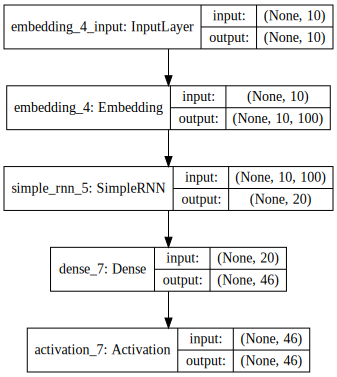

In [20]:
# Create the model
model = Sequential()

# This is the most basic kind of RNN!  We're using 20 units, 
# which somewhat reflects our "memory" of past events in a sequence
model.add(Embedding(input_dim=max_features, output_dim=100, embeddings_initializer="glorot_uniform", input_length=maxlen))
# This is the most basic kind of RNN!  We're using 20 units, 
model.add(SimpleRNN(20, return_sequences=False))
model.add(Dense(46))  # number of classes
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
# refresh localhost: 9000
cb=keras.callbacks.RemoteMonitor(root='http://localhost:9000')

model.fit(X_train,y_train,epochs=20,
         validation_data=(X_test,y_test),callbacks=[cb])

Train on 8982 samples, validate on 2246 samples
Epoch 1/20
8982/8982 [==============================] - 2s - loss: 1.5753 - acc: 0.5950 - val_loss: 2.1755 - val_acc: 0.4448
Epoch 2/20
8982/8982 [==============================] - 2s - loss: 1.5533 - acc: 0.6006 - val_loss: 2.1883 - val_acc: 0.4466
Epoch 3/20
8982/8982 [==============================] - 2s - loss: 1.5340 - acc: 0.6074 - val_loss: 2.2049 - val_acc: 0.4448
Epoch 4/20
8982/8982 [==============================] - 1s - loss: 1.5109 - acc: 0.6145 - val_loss: 2.2210 - val_acc: 0.4457
Epoch 5/20
8982/8982 [==============================] - ETA: 0s - loss: 1.4878 - acc: 0.624 - 1s - loss: 1.4913 - acc: 0.6226 - val_loss: 2.2382 - val_acc: 0.4452
Epoch 6/20
8982/8982 [==============================] - 1s - loss: 1.4703 - acc: 0.6318 - val_loss: 2.2546 - val_acc: 0.4448
Epoch 7/20
8982/8982 [==============================] - 1s - loss: 1.4498 - acc: 0.6383 - val_loss: 2.2795 - val_acc: 0.4421
Epoch 8/20
8982/8982 [=================

####  What do you notice about the training results ?
- 200% improvement over ANN. 
- Let's improve ! 

### LSTM  - Long Short Term Memory

<img src='../imgs/lstm_3_anno.png'/>
<img src='../imgs/lstm_eqn.png'/>

[credits: Colah's Blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

#### Ex 3: Last time with Reuters newswire via LSTM

### Code Along!

1) Run the following LSTM model.     
- We see a moderate improvement from our RNN model.  How can we improve this further? 

Hints: 
* Adjust # of memory units
* Compare & contrast different optimizers
* Shit-tab to read LSTM & Embedding DocStrings.  Experiment with other arguments.

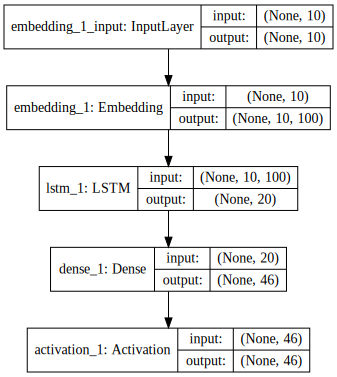

In [ ]:
# 1st run through, LSTM with SGD
model = Sequential()

model.add(Embedding(input_dim=max_features, output_dim=100, embeddings_initializer="glorot_uniform", input_length=maxlen))

model.add(LSTM(20, return_sequences=False)) # again 20 'memory' units
model.add(Dense(46))  # number of classes
model.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

np.random.seed(123)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
# refresh localhost: 9000
cb=keras.callbacks.RemoteMonitor(root='http://localhost:9000')

model.fit(X_train,y_train,epochs=20,
         validation_data=(X_test,y_test),callbacks=[cb])

<img src='../imgs/learning_a.png'/>

In [65]:
# 2nd run through - let's just change the optimizer
model = Sequential()

model.add(Embedding(input_dim=max_features, output_dim=100, embeddings_initializer="glorot_uniform", input_length=maxlen))

model.add(LSTM(20, return_sequences=False)) # again 20 'memory' units
model.add(Dense(46))  # number of classes
model.add(Activation('softmax'))

np.random.seed(123)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [23]:
# refresh localhost: 9000
cb=keras.callbacks.RemoteMonitor(root='http://localhost:9000')

model.fit(X_train,y_train,epochs=20,
         validation_data=(X_test,y_test),callbacks=[cb])

Train on 8982 samples, validate on 2246 samples
Epoch 1/20
8982/8982 [==============================] - 3s - loss: 2.6037 - acc: 0.3456 - val_loss: 2.1851 - val_acc: 0.3909
Epoch 2/20
8982/8982 [==============================] - 3s - loss: 2.1098 - acc: 0.4318 - val_loss: 2.0929 - val_acc: 0.4377
Epoch 3/20
8982/8982 [==============================] - 3s - loss: 2.0224 - acc: 0.4589 - val_loss: 2.0427 - val_acc: 0.4599
Epoch 4/20
8982/8982 [==============================] - 3s - loss: 1.9702 - acc: 0.4667 - val_loss: 2.0125 - val_acc: 0.4675
Epoch 5/20
8982/8982 [==============================] - 3s - loss: 1.9248 - acc: 0.4825 - val_loss: 1.9972 - val_acc: 0.4773
Epoch 6/20
8982/8982 [==============================] - 3s - loss: 1.8895 - acc: 0.4994 - val_loss: 1.9769 - val_acc: 0.4858
Epoch 7/20
8982/8982 [==============================] - 3s - loss: 1.8577 - acc: 0.5100 - val_loss: 1.9741 - val_acc: 0.4893
Epoch 8/20
8982/8982 [==============================] - 3s - loss: 1.8327 - a

<img src='../imgs/learning_b.png'/>

In [4]:
# 3rd run through - change # nodes of LSTM memory layer
model = Sequential()

model.add(Embedding(input_dim=max_features, output_dim=500, embeddings_initializer="glorot_uniform", input_length=maxlen))

model.add(LSTM(256, return_sequences=False, dropout_W=0.2, dropout_U=0.2)) # again 20 'memory' units
model.add(Dense(46))  # number of classes
model.add(Activation('softmax'))

np.random.seed(123)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

NameError: name 'maxlen' is not defined

In [ ]:
# refresh localhost: 9000
cb=keras.callbacks.RemoteMonitor(root='http://localhost:9000')

model.fit(X_train,y_train,epochs=20,
         validation_data=(X_test,y_test),callbacks=[cb])

<img src='../imgs/learning_c.png'/>

##  Bidirectional Recurrent Neural Networks (RNN)
- Bidirectionall RNNs simply connect in both directions
- Thus, output can be dependent on both future and past inputs
- Good for context around a word, for instance
  - e.g. Named Entity Recognition, is this a "person" token?


<img src="imgs/brnn_a.png"/>


In [72]:
max_features = 20000
maxlen = 10  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

Loading data...
25000 train sequences
25000 test sequences


In [82]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
# Bidirectional LSTM!!!
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.5))
model.add(Dense(46, activation='sigmoid'))



In [80]:
# about 5 minute runtime
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])


# reset localhost:9000
cb=keras.callbacks.RemoteMonitor(root='http://localhost:9000')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=[X_test, y_test])

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 53s - loss: 0.8155 - acc: 0.4984 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 2/5
25000/25000 [==============================] - 73s - loss: 0.6935 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5000.50
Epoch 3/5
25000/25000 [==============================] - 74s - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/5
25000/25000 [==============================] - 69s - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/5
25000/25000 [==============================] - 71s - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.5000


## Text Generation with LSTM & shakespeare

In [3]:
file='../data/alllines.txt'  # read in shakespeare from our local file
text = open(file).read().lower()
print('corpus length:', len(text))
print ('\n')
print (text[:108])

# let's just take the first 500K
text=text[:500000]

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

corpus length: 4583798


"act i"
"scene i. london. the palace."
"enter king henry, lord john of lancaster, the earl of westmoreland, 
total chars: 44


In [8]:
list(char_indices.items())[18:25]

[('a', 18), ('b', 19), ('c', 20), ('d', 21), ('e', 22), ('f', 23), ('g', 24)]

In [23]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step): #moving through by step size 3
    sentences.append(text[i: i + maxlen]) # get 40 characters
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))


print(sentences[999])
print(next_chars[999])
print('\n')
print('\n')
print(sentences[1000])
print(next_chars[1000])

nb sequences: 166654
th brought us smooth and welcome news."

"




brought us smooth and welcome news."
"th
e


In [24]:
print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [29]:
X.shape   # num sentences x sentence length x unique characters

X[0][0]  # pulling out an observation

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False], dtype=bool)

In [ ]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
losses=[]
for iteration in range(1, 60):
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, nb_epoch=1)

    start_index = np.random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

##  Additional Challenges & Work Alongs: 

1) On your GPU, repeat the Reuters Newswire Problem : leverages a LSTM together with A CNN!       
- compare these reseults with your previous results.

2) Develop another text generation model using alternate data sources: 
    (data ref options)
     - https://s3.amazonaws.com/text-datasets/nietzsche.txt
     - [create lyrics from your favorite artist](https://www.kaggle.com/mousehead/songlyrics/data)
     - any other dataset of your choice! 

In [ ]:


# Training
batch_size = 10

'''
Note:
batch_size is highly sensitive.
Only 2 epochs are needed as the dataset is very small.
'''

print('Build model...')

embedding_size =100

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
# Convolution!
model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=1))
model.add(MaxPooling1D(pool_length=pool_length))
model.add(LSTM(lstm_output_size))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=10,
          validation_data=(X_test, y_test))
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)